## First attempt at modeling

`GOALS:` 
- Create a simple model that predicts if the client will not show
- then apply the stats to see how much money the clinic would save if they could predict no-shows
- Lastly assign a probability to each client of not showing up based off the models predictions, that be used in a cost-benefit analysis. 
- See if the model could be applied to scheduled appointments so the clinic could double book appointments
    - need to caluclate the failed predictions where both clients show up
    - both clients don't show up 
    - one client shows up.

In [349]:
# importing all of the libraries
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [350]:
# opening data with polars 
df = pl.read_csv('data.csv', ignore_errors=True)
df = df.to_pandas()
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [351]:
# making all of the coulmns lowercase
df.columns = map(str.lower, df.columns)
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [352]:
# converting no-show to 1 for no and 0 for yes
df['no-show'] = df['no-show'].replace({'No': 'Showed', 'Yes': 'No Show'})

## `Data Processing and Data Cleaning`

In [353]:
# dropping all rows from the data frame with the ages, 0, and -1
df = df[(df['age'] > 0)]
df.age.min()
df.age.max()

115

In [354]:
# getting the data types of the columns
df.dtypes

# Converting the gender column to int64 data type, Male = 1, Female = 0
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Converting scheduledday and appointmentday to datetime
df['scheduledday'] = pd.to_datetime(df['scheduledday'])
df['appointmentday'] = pd.to_datetime(df['appointmentday'])

# Stripping the time from the scheduledday and appointmentday so it is just the date
df['scheduledday'] = df['scheduledday'].dt.normalize()
df['appointmentday'] = df['appointmentday'].dt.normalize()

# Define the age bins and corresponding labels
age_bins = [0, 10, 18, 26, 65, np.inf]
age_labels = ['Child (0-10)', 'Youth (10-17)', 'Young Adult (18-25)', 'Adult (26-65)', 'Senior (65+)']

# Create a new column for the age group
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# Now making a column for the days between the scheduled day and the appointment day for each appointmentid
df['date_diff'] = (df['appointmentday'] - df['scheduledday']).dt.days

# Display the resulting DataFrame
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,age_group,date_diff
0,2.987250e+13,5642903,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,Showed,Adult (26-65),0
1,5.589978e+14,5642503,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,Showed,Adult (26-65),0
2,4.262962e+12,5642549,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,Showed,Adult (26-65),0
3,8.679512e+11,5642828,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,Showed,Child (0-10),0
4,8.841186e+12,5642494,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,Showed,Adult (26-65),0


In [355]:
# getting the min and the max of the date_diff column
df['date_diff'].min(), df['date_diff'].max()

(-6, 179)

In [356]:
# getting the counts for all of the date_diff values and making it a data frame called date_diff_counts
date_diff_counts = df['date_diff'].value_counts().reset_index()
date_diff_counts.columns = ['date_diff', 'count']
date_diff_counts 

,date_diff,count
0,0,37154
1,2,6636
2,4,5212
3,1,5028
4,7,4785
...,...,...
126,126,1
127,101,1
128,125,1
129,127,1


### `Very impotant note!`
##### Looking at the data difference, I noticed that there was approx 37 thousand appointments that had a date diffrence of -1. This removes a massive amount of training data. So to solve this, we are going to make the assumption that the appointment was a walk in, and we are going to mark anything lower than 1 as Zero, and we will take it a Same Day appointment. 

In [357]:
# making all negative values in the date_diff column to 0
df.loc[df['date_diff'] < 0, 'date_diff'] = 0

In [358]:
# min and max
df['date_diff'].min(), df['date_diff'].max()

(0, 179)

In [359]:
# Making a new column 'same_day_appointment'
df['same_day_appointment'] = df['date_diff'].apply(lambda x: 1 if x == 0 else 0)

In [360]:
# now making a made_day_otw column for the day of the week the appointment was made
df['made_day_otw'] = df['scheduledday'].dt.day_name()

# now making a appt_day_otw column for the day of the week the appointment was
df['appt_day_otw'] = df['appointmentday'].dt.day_name()

# making maps for the days of the week to convert them to numbers
day_map = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}

# now applying the maps to the made_day_otw and appt_day_otw columns
df['made_day_otw'] = df['made_day_otw'].map(day_map)
df['appt_day_otw'] = df['appt_day_otw'].map(day_map)

df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,age_group,date_diff,same_day_appointment,made_day_otw,appt_day_otw
0,2.987250e+13,5642903,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,Showed,Adult (26-65),0,1,4,4
1,5.589978e+14,5642503,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,Showed,Adult (26-65),0,1,4,4
2,4.262962e+12,5642549,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,Showed,Adult (26-65),0,1,4,4
3,8.679512e+11,5642828,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,Showed,Child (0-10),0,1,4,4
4,8.841186e+12,5642494,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,Showed,Adult (26-65),0,1,4,4


In [361]:
# printing all of the unique values in the columns
print(df['neighbourhood'].unique())

# printinging the number of unique values in the neighbourhood column
print(df['neighbourhood'].nunique())

['JARDIM DA PENHA' 'MATA DA PRAIA' 'PONTAL DE CAMBURI' 'REPÚBLICA'
 'GOIABEIRAS' 'ANDORINHAS' 'CONQUISTA' 'NOVA PALESTINA' 'DA PENHA'
 'TABUAZEIRO' 'BENTO FERREIRA' 'SÃO PEDRO' 'SANTA MARTHA' 'SÃO CRISTÓVÃO'
 'MARUÍPE' 'GRANDE VITÓRIA' 'SANTO ANDRÉ' 'SOLON BORGES' 'BONFIM'
 'JARDIM CAMBURI' 'MARIA ORTIZ' 'JABOUR' 'ANTÔNIO HONÓRIO' 'RESISTÊNCIA'
 'ILHA DE SANTA MARIA' 'JUCUTUQUARA' 'MÁRIO CYPRESTE' 'SANTO ANTÔNIO'
 'BELA VISTA' 'PRAIA DO SUÁ' 'SANTA HELENA' 'ITARARÉ' 'INHANGUETÁ'
 'UNIVERSITÁRIO' 'SÃO JOSÉ' 'REDENÇÃO' 'SANTA CLARA' 'CENTRO'
 'PARQUE MOSCOSO' 'DO MOSCOSO' 'SANTOS DUMONT' 'CARATOÍRA'
 'ARIOVALDO FAVALESSA' 'ILHA DO FRADE' 'GURIGICA' 'JOANA D´ARC'
 'CONSOLAÇÃO' 'SÃO BENEDITO' 'PRAIA DO CANTO' 'BOA VISTA' 'SANTA LÚCIA'
 'BARRO VERMELHO' 'ESTRELINHA' 'FORTE SÃO JOÃO' 'FONTE GRANDE'
 'MORADA DE CAMBURI' 'ENSEADA DO SUÁ' 'SANTOS REIS' 'PIEDADE'
 'JESUS DE NAZARETH' 'SANTA LUÍZA' 'SANTA TEREZA' 'CRUZAMENTO'
 'ILHA DO PRÍNCIPE' 'ROMÃO' 'ILHA DAS CAIEIRAS' 'COMDUSA' 'SANTA CECÍLI

In [362]:
# Using pd.factorize to map unique values to integers
df['neighbourhood_code'], uniques = pd.factorize(df['neighbourhood'])

# Display the resulting DataFrame and the mapping
print(df[['neighbourhood', 'neighbourhood_code']].head())
print(dict(enumerate(uniques)))

       neighbourhood  neighbourhood_code
0    JARDIM DA PENHA                   0
1    JARDIM DA PENHA                   0
2      MATA DA PRAIA                   1
3  PONTAL DE CAMBURI                   2
4    JARDIM DA PENHA                   0
{0: 'JARDIM DA PENHA', 1: 'MATA DA PRAIA', 2: 'PONTAL DE CAMBURI', 3: 'REPÚBLICA', 4: 'GOIABEIRAS', 5: 'ANDORINHAS', 6: 'CONQUISTA', 7: 'NOVA PALESTINA', 8: 'DA PENHA', 9: 'TABUAZEIRO', 10: 'BENTO FERREIRA', 11: 'SÃO PEDRO', 12: 'SANTA MARTHA', 13: 'SÃO CRISTÓVÃO', 14: 'MARUÍPE', 15: 'GRANDE VITÓRIA', 16: 'SANTO ANDRÉ', 17: 'SOLON BORGES', 18: 'BONFIM', 19: 'JARDIM CAMBURI', 20: 'MARIA ORTIZ', 21: 'JABOUR', 22: 'ANTÔNIO HONÓRIO', 23: 'RESISTÊNCIA', 24: 'ILHA DE SANTA MARIA', 25: 'JUCUTUQUARA', 26: 'MÁRIO CYPRESTE', 27: 'SANTO ANTÔNIO', 28: 'BELA VISTA', 29: 'PRAIA DO SUÁ', 30: 'SANTA HELENA', 31: 'ITARARÉ', 32: 'INHANGUETÁ', 33: 'UNIVERSITÁRIO', 34: 'SÃO JOSÉ', 35: 'REDENÇÃO', 36: 'SANTA CLARA', 37: 'CENTRO', 38: 'PARQUE MOSCOSO', 39: 'DO MOSCO

In [363]:
# now mapping the age group column to numbers
age_group_map = {'Child (0-10)': 0, 'Youth (10-17)': 1, 'Young Adult (18-25)': 2, 'Adult (26-65)': 3, 'Senior (65+)': 4}
df['age_group'] = df['age_group'].map(age_group_map)
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,age_group,date_diff,same_day_appointment,made_day_otw,appt_day_otw,neighbourhood_code
0,2.987250e+13,5642903,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,Showed,3,0,1,4,4,0
1,5.589978e+14,5642503,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,Showed,3,0,1,4,4,0
2,4.262962e+12,5642549,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,Showed,3,0,1,4,4,1
3,8.679512e+11,5642828,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,Showed,0,0,1,4,4,2
4,8.841186e+12,5642494,0,2016-04-29 00:00:00+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,Showed,3,0,1,4,4,0


In [364]:
df_cleaned = df.copy()

In [365]:
# dropping the columns that are not needed now
df_experiment = df.copy()
df_experiment = df_experiment.drop(columns= ['neighbourhood', 'scheduledday'])

df = df.drop(columns=['neighbourhood', 'scheduledday', 'appointmentday'])
df.columns

Index(['patientid', 'appointmentid', 'gender', 'age', 'scholarship',
       'hipertension', 'diabetes', 'alcoholism', 'handcap', 'sms_received',
       'no-show', 'age_group', 'date_diff', 'same_day_appointment',
       'made_day_otw', 'appt_day_otw', 'neighbourhood_code'],
      dtype='object')

In [366]:
df

,patientid,appointmentid,gender,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,age_group,date_diff,same_day_appointment,made_day_otw,appt_day_otw,neighbourhood_code
0,2.987250e+13,5642903,0,62,0,1,0,0,0,0,Showed,3,0,1,4,4,0
1,5.589978e+14,5642503,0,56,0,0,0,0,0,0,Showed,3,0,1,4,4,0
2,4.262962e+12,5642549,0,62,0,0,0,0,0,0,Showed,3,0,1,4,4,1
3,8.679512e+11,5642828,0,8,0,0,0,0,0,0,Showed,0,0,1,4,4,2
4,8.841186e+12,5642494,0,56,0,1,1,0,0,0,Showed,3,0,1,4,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,0,56,0,0,0,0,0,1,Showed,3,35,0,1,1,20
110523,3.596266e+12,5650093,0,51,0,0,0,0,0,1,Showed,3,35,0,1,1,20
110524,1.557663e+13,5630692,0,21,0,0,0,0,0,1,Showed,2,41,0,2,1,20
110525,9.213493e+13,5630323,0,38,0,0,0,0,0,1,Showed,3,41,0,2,1,20


In [367]:
df_experiment

,patientid,appointmentid,gender,appointmentday,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,age_group,date_diff,same_day_appointment,made_day_otw,appt_day_otw,neighbourhood_code
0,2.987250e+13,5642903,0,2016-04-29 00:00:00+00:00,62,0,1,0,0,0,0,Showed,3,0,1,4,4,0
1,5.589978e+14,5642503,0,2016-04-29 00:00:00+00:00,56,0,0,0,0,0,0,Showed,3,0,1,4,4,0
2,4.262962e+12,5642549,0,2016-04-29 00:00:00+00:00,62,0,0,0,0,0,0,Showed,3,0,1,4,4,1
3,8.679512e+11,5642828,0,2016-04-29 00:00:00+00:00,8,0,0,0,0,0,0,Showed,0,0,1,4,4,2
4,8.841186e+12,5642494,0,2016-04-29 00:00:00+00:00,56,0,1,1,0,0,0,Showed,3,0,1,4,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,0,2016-06-07 00:00:00+00:00,56,0,0,0,0,0,1,Showed,3,35,0,1,1,20
110523,3.596266e+12,5650093,0,2016-06-07 00:00:00+00:00,51,0,0,0,0,0,1,Showed,3,35,0,1,1,20
110524,1.557663e+13,5630692,0,2016-06-07 00:00:00+00:00,21,0,0,0,0,0,1,Showed,2,41,0,2,1,20
110525,9.213493e+13,5630323,0,2016-06-07 00:00:00+00:00,38,0,0,0,0,0,1,Showed,3,41,0,2,1,20


# Model Selection

##### `Random Forest`




In [368]:
# Libraries for the Random forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

features = ['gender',
            'age',
            'scholarship',
            'hipertension',
            'diabetes',
            'alcoholism',
            'handcap',
            'sms_received',
            'age_group',
            'date_diff',
            'same_day_appointment',
            'made_day_otw',
            'appt_day_otw', 
            'neighbourhood_code'
            ]

x = df[features]
y = df['no-show']

In [369]:
# splitting the data into the training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [371]:
# Creating 3 random forest models with 100, 200, and 300 trees

# Creating a dictionary to hold the models
models = {}

sizes = [100, 200, 300]

for size in sizes:
    model_name = f"model_{size}_trees"
    model = RandomForestClassifier(n_estimators=size, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    # Save the model to the dictionary
    models[model_name] = model
    
    # Accuracy Score
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy with {model_name}: {accuracy}")
    
    # Classification Report
    class_report = classification_report(y_test, y_pred)
    print(f"Classification Report with {model_name}:\n{class_report}")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix with {model_name}:\n{conf_matrix}")

Accuracy with model_100_trees: 0.7719880362650715
Classification Report with model_100_trees:
              precision    recall  f1-score   support

     No Show       0.39      0.22      0.28      4325
      Showed       0.82      0.91      0.86     17073

    accuracy                           0.77     21398
   macro avg       0.60      0.57      0.57     21398
weighted avg       0.73      0.77      0.75     21398

Confusion Matrix with model_100_trees:
[[  954  3371]
 [ 1508 15565]]
Accuracy with model_200_trees: 0.7725021030002804
Classification Report with model_200_trees:
              precision    recall  f1-score   support

     No Show       0.39      0.21      0.27      4325
      Showed       0.82      0.91      0.87     17073

    accuracy                           0.77     21398
   macro avg       0.60      0.56      0.57     21398
weighted avg       0.73      0.77      0.75     21398

Confusion Matrix with model_200_trees:
[[  919  3406]
 [ 1462 15611]]
Accuracy with mode

## Model Performance with Different Numbers of Trees
### NOTE: Class 0 is that they did not show, and Class 1 is that they did show.

#

### `So what does this mean for us when we apply this to a real-world scenario?`

#### - We are able to predcit with a 77% accuracy if a client will not show up to their appointment, but we can not predict if they will show up.
#### - That being said, we can apply this to the clinic to see the probability of the client not showing up for their appointment given the input data, and get our prejected no-show rate, ratio, or percent for the day. 

### `In these next couple blocks of code, We are going to be making a new data frame to see how accurate the model is each day`

In [378]:
# From the df_cleaned data frame, we are going to make a new data frame called 'test', that just includes the appointmentday
test = df_cleaned[['appointmentday']].drop_duplicates().reset_index(drop=True)

# Calculating the actual count of no-show appointments for each day
no_show_counts = df_cleaned[df_cleaned['no-show'] == 'No Show'].groupby('appointmentday').size().reset_index(name='actual_no_show_count')
test = test.merge(no_show_counts, on='appointmentday', how='left')
test['actual_no_show_count'] = test['actual_no_show_count'].fillna(0)

# doing the same thing for the show counts
show_counts = df_cleaned[df_cleaned['no-show'] == 'Showed'].groupby('appointmentday').size().reset_index(name='actual_show_count')
test = test.merge(show_counts, on='appointmentday', how='left')
test['actual_show_count'] = test['actual_show_count'].fillna(0)

# doing some calculations for the new columns
test['actual_appointment_count'] = test['actual_no_show_count'] + test['actual_show_count']

test

,appointmentday,actual_no_show_count,actual_show_count,actual_appointment_count
0,2016-04-29 00:00:00+00:00,608,2496,3104
1,2016-05-03 00:00:00+00:00,807,3322,4129
2,2016-05-10 00:00:00+00:00,965,3212,4177
3,2016-05-17 00:00:00+00:00,912,3315,4227
4,2016-05-24 00:00:00+00:00,791,3085,3876
5,2016-05-31 00:00:00+00:00,753,3405,4158
6,2016-05-02 00:00:00+00:00,833,3381,4214
7,2016-05-30 00:00:00+00:00,856,3504,4360
8,2016-05-16 00:00:00+00:00,1010,3439,4449
9,2016-05-04 00:00:00+00:00,945,3103,4048


In [373]:
# making a new column in the df_experiment data frame called 'no_show_prediction' and setting them all to NaN
df_experiment['no_show_prediction'] = np.nan

# setting up the input columns for the model to predict the no-shows

input_cols =[
            'gender',
            'age',
            'scholarship',
            'hipertension',
            'diabetes',
            'alcoholism',
            'handcap',
            'sms_received',
            'age_group',
            'date_diff',
            'same_day_appointment',
            'made_day_otw',
            'appt_day_otw', 
            'neighbourhood_code'
            ]


df_experiment

,patientid,appointmentid,gender,appointmentday,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,age_group,date_diff,same_day_appointment,made_day_otw,appt_day_otw,neighbourhood_code,no_show_prediction
0,2.987250e+13,5642903,0,2016-04-29 00:00:00+00:00,62,0,1,0,0,0,0,Showed,3,0,1,4,4,0,NaN
1,5.589978e+14,5642503,0,2016-04-29 00:00:00+00:00,56,0,0,0,0,0,0,Showed,3,0,1,4,4,0,NaN
2,4.262962e+12,5642549,0,2016-04-29 00:00:00+00:00,62,0,0,0,0,0,0,Showed,3,0,1,4,4,1,NaN
3,8.679512e+11,5642828,0,2016-04-29 00:00:00+00:00,8,0,0,0,0,0,0,Showed,0,0,1,4,4,2,NaN
4,8.841186e+12,5642494,0,2016-04-29 00:00:00+00:00,56,0,1,1,0,0,0,Showed,3,0,1,4,4,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,0,2016-06-07 00:00:00+00:00,56,0,0,0,0,0,1,Showed,3,35,0,1,1,20,NaN
110523,3.596266e+12,5650093,0,2016-06-07 00:00:00+00:00,51,0,0,0,0,0,1,Showed,3,35,0,1,1,20,NaN
110524,1.557663e+13,5630692,0,2016-06-07 00:00:00+00:00,21,0,0,0,0,0,1,Showed,2,41,0,2,1,20,NaN
110525,9.213493e+13,5630323,0,2016-06-07 00:00:00+00:00,38,0,0,0,0,0,1,Showed,3,41,0,2,1,20,NaN


In [374]:
# Extract the model with 300 trees from the dictionary
model_300_trees = models['model_300_trees']

# Ensure the input columns are present in df_experiment
X_experiment = df_experiment[input_cols]

# Make predictions using the model
df_experiment['no_show_prediction'] = model_300_trees.predict(X_experiment)

# Display the resulting DataFrame
df_experiment


,patientid,appointmentid,gender,appointmentday,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,age_group,date_diff,same_day_appointment,made_day_otw,appt_day_otw,neighbourhood_code,no_show_prediction
0,2.987250e+13,5642903,0,2016-04-29 00:00:00+00:00,62,0,1,0,0,0,0,Showed,3,0,1,4,4,0,Showed
1,5.589978e+14,5642503,0,2016-04-29 00:00:00+00:00,56,0,0,0,0,0,0,Showed,3,0,1,4,4,0,Showed
2,4.262962e+12,5642549,0,2016-04-29 00:00:00+00:00,62,0,0,0,0,0,0,Showed,3,0,1,4,4,1,Showed
3,8.679512e+11,5642828,0,2016-04-29 00:00:00+00:00,8,0,0,0,0,0,0,Showed,0,0,1,4,4,2,Showed
4,8.841186e+12,5642494,0,2016-04-29 00:00:00+00:00,56,0,1,1,0,0,0,Showed,3,0,1,4,4,0,Showed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,0,2016-06-07 00:00:00+00:00,56,0,0,0,0,0,1,Showed,3,35,0,1,1,20,No Show
110523,3.596266e+12,5650093,0,2016-06-07 00:00:00+00:00,51,0,0,0,0,0,1,Showed,3,35,0,1,1,20,Showed
110524,1.557663e+13,5630692,0,2016-06-07 00:00:00+00:00,21,0,0,0,0,0,1,Showed,2,41,0,2,1,20,Showed
110525,9.213493e+13,5630323,0,2016-06-07 00:00:00+00:00,38,0,0,0,0,0,1,Showed,3,41,0,2,1,20,Showed


In [379]:
# Now we are goign to bring the prediction data into the test data frame and do some calculations
# Calculate the predicted count of no-show appointments for each day
no_show_predictions = df_experiment[df_experiment['no_show_prediction'] == 'No Show'].groupby('appointmentday').size().reset_index(name='predicted_no_show_count')
test = test.merge(no_show_predictions, on='appointmentday', how='left')
test['predicted_no_show_count'] = test['predicted_no_show_count'].fillna(0)

# Calculate the predicted count of show appointments for each day
show_predictions = df_experiment[df_experiment['no_show_prediction'] == 'Showed'].groupby('appointmentday').size().reset_index(name='predicted_show_count')
test = test.merge(show_predictions, on='appointmentday', how='left')
test['predicted_show_count'] = test['predicted_show_count'].fillna(0)



# Display the resulting DataFrame
test

,appointmentday,actual_no_show_count,actual_show_count,actual_appointment_count,predicted_no_show_count,predicted_show_count
0,2016-04-29 00:00:00+00:00,608,2496,3104,552,2552
1,2016-05-03 00:00:00+00:00,807,3322,4129,703,3426
2,2016-05-10 00:00:00+00:00,965,3212,4177,815,3362
3,2016-05-17 00:00:00+00:00,912,3315,4227,776,3451
4,2016-05-24 00:00:00+00:00,791,3085,3876,660,3216
5,2016-05-31 00:00:00+00:00,753,3405,4158,635,3523
6,2016-05-02 00:00:00+00:00,833,3381,4214,671,3543
7,2016-05-30 00:00:00+00:00,856,3504,4360,740,3620
8,2016-05-16 00:00:00+00:00,1010,3439,4449,887,3562
9,2016-05-04 00:00:00+00:00,945,3103,4048,775,3273


In [380]:
# performing some calculations on the data frame 

# getting the difference between the actual and predicted no-shows
test['no_show_diff'] = test['actual_no_show_count'] - test['predicted_no_show_count']

# getting the difference between the actual and predicted shows
test['show_diff'] = test['actual_show_count'] - test['predicted_show_count']

test

,appointmentday,actual_no_show_count,actual_show_count,actual_appointment_count,predicted_no_show_count,predicted_show_count,no_show_diff,show_diff
0,2016-04-29 00:00:00+00:00,608,2496,3104,552,2552,56,-56
1,2016-05-03 00:00:00+00:00,807,3322,4129,703,3426,104,-104
2,2016-05-10 00:00:00+00:00,965,3212,4177,815,3362,150,-150
3,2016-05-17 00:00:00+00:00,912,3315,4227,776,3451,136,-136
4,2016-05-24 00:00:00+00:00,791,3085,3876,660,3216,131,-131
5,2016-05-31 00:00:00+00:00,753,3405,4158,635,3523,118,-118
6,2016-05-02 00:00:00+00:00,833,3381,4214,671,3543,162,-162
7,2016-05-30 00:00:00+00:00,856,3504,4360,740,3620,116,-116
8,2016-05-16 00:00:00+00:00,1010,3439,4449,887,3562,123,-123
9,2016-05-04 00:00:00+00:00,945,3103,4048,775,3273,170,-170


In [381]:
# getting the difference between the predictied no shows and the actual no shows as a percentage 
test['no_show_diff_percentage'] = (test['no_show_diff'] / test['actual_no_show_count']) * 100
test['no_show_diff_percentage'] = test['no_show_diff_percentage'].fillna(0)
test

,appointmentday,actual_no_show_count,actual_show_count,actual_appointment_count,predicted_no_show_count,predicted_show_count,no_show_diff,show_diff,no_show_diff_percentage
0,2016-04-29 00:00:00+00:00,608,2496,3104,552,2552,56,-56,9.210526
1,2016-05-03 00:00:00+00:00,807,3322,4129,703,3426,104,-104,12.887237
2,2016-05-10 00:00:00+00:00,965,3212,4177,815,3362,150,-150,15.544041
3,2016-05-17 00:00:00+00:00,912,3315,4227,776,3451,136,-136,14.912281
4,2016-05-24 00:00:00+00:00,791,3085,3876,660,3216,131,-131,16.561315
5,2016-05-31 00:00:00+00:00,753,3405,4158,635,3523,118,-118,15.670651
6,2016-05-02 00:00:00+00:00,833,3381,4214,671,3543,162,-162,19.447779
7,2016-05-30 00:00:00+00:00,856,3504,4360,740,3620,116,-116,13.551402
8,2016-05-16 00:00:00+00:00,1010,3439,4449,887,3562,123,-123,12.178218
9,2016-05-04 00:00:00+00:00,945,3103,4048,775,3273,170,-170,17.989418


In [382]:
# getting the avg no show percentage
avg_no_show_diff_percentage = test['no_show_diff_percentage'].mean()
avg_no_show_diff_percentage

14.284702988682874

### The final percent is basically saying that our model is going to be prediciting 14% less no-shows than what actually happened, and will attribute the 14% to them showing up. So we can expect an approximate 14% error rate in our model, with 14% no shows actually accuring than what is predicted. We are going to attempt to fix this, by adding an extra 10% to the daily no-show rate, and see if that helps, with our genderal accuracy. 

### `Plotting our model's daily no show rate % `

c:\Users\tehwh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tehwh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


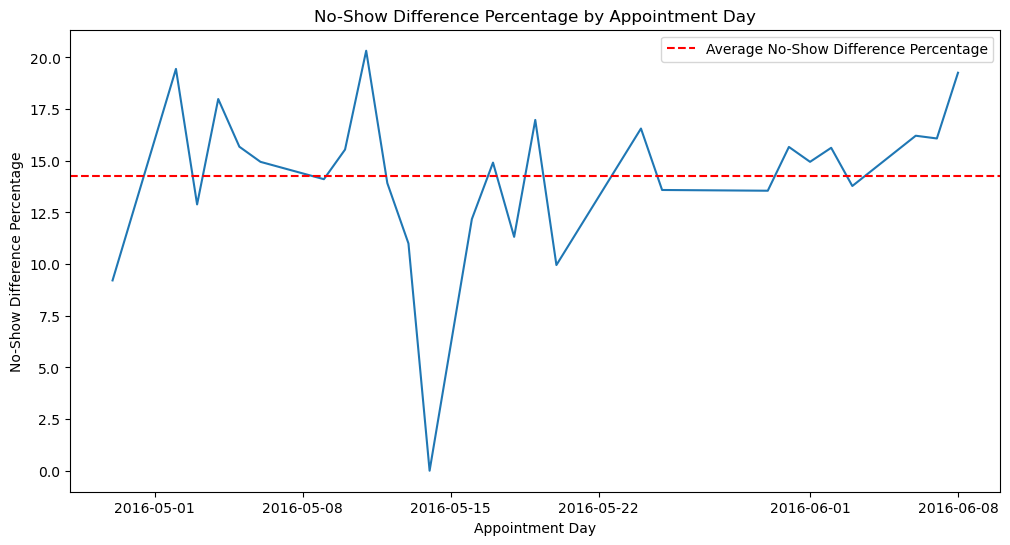

In [383]:
# plotting the no_show_diff_percentage column by the date 
plt.figure(figsize=(12, 6))
sns.lineplot(x='appointmentday', y='no_show_diff_percentage', data=test)
plt.axhline(avg_no_show_diff_percentage, color='red', linestyle='--', label='Average No-Show Difference Percentage')
plt.title('No-Show Difference Percentage by Appointment Day')
plt.xlabel('Appointment Day')
plt.ylabel('No-Show Difference Percentage')
plt.legend()
plt.show()

In [385]:
# now we are going to add an additional 10% to the 'predicted_no_show_count' column and name it the 'adjusted_no_show_pred' and then make a new column called 'adjusted_no_show_diff_%'

# Adding an additional 10% to the 'predicted_no_show_count' and creating 'adjusted_no_show_pred'
test['adjusted_no_show_pred'] = test['predicted_no_show_count'] * 1.1 

# rounding the 'adjusted_no_show_pred' column to nearest whole number
test['adjusted_no_show_pred'] = test['adjusted_no_show_pred'].round(0)

# Creating 'adjusted_no_show_diff_%' to calculate the difference percentage
test['adjusted_no_show_diff_%'] = ((test['actual_no_show_count'] - test['adjusted_no_show_pred']) / test['actual_no_show_count']) * 100

# Handling potential division by zero
test['adjusted_no_show_diff_%'] = test['adjusted_no_show_diff_%'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Display the resulting DataFrame
test

,appointmentday,actual_no_show_count,actual_show_count,actual_appointment_count,predicted_no_show_count,predicted_show_count,no_show_diff,show_diff,no_show_diff_percentage,adjusted_no_show_pred,adjusted_no_show_diff_%
0,2016-04-29 00:00:00+00:00,608,2496,3104,552,2552,56,-56,9.210526,607.0,0.164474
1,2016-05-03 00:00:00+00:00,807,3322,4129,703,3426,104,-104,12.887237,773.0,4.213135
2,2016-05-10 00:00:00+00:00,965,3212,4177,815,3362,150,-150,15.544041,897.0,7.046632
3,2016-05-17 00:00:00+00:00,912,3315,4227,776,3451,136,-136,14.912281,854.0,6.359649
4,2016-05-24 00:00:00+00:00,791,3085,3876,660,3216,131,-131,16.561315,726.0,8.217446
5,2016-05-31 00:00:00+00:00,753,3405,4158,635,3523,118,-118,15.670651,698.0,7.304117
6,2016-05-02 00:00:00+00:00,833,3381,4214,671,3543,162,-162,19.447779,738.0,11.404562
7,2016-05-30 00:00:00+00:00,856,3504,4360,740,3620,116,-116,13.551402,814.0,4.906542
8,2016-05-16 00:00:00+00:00,1010,3439,4449,887,3562,123,-123,12.178218,976.0,3.366337
9,2016-05-04 00:00:00+00:00,945,3103,4048,775,3273,170,-170,17.989418,853.0,9.735450


In [387]:
avg_no_show_diff_percentage_adjusted = test['adjusted_no_show_diff_%'].mean()
avg_no_show_diff_percentage_adjusted

5.66942125177916

c:\Users\tehwh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tehwh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


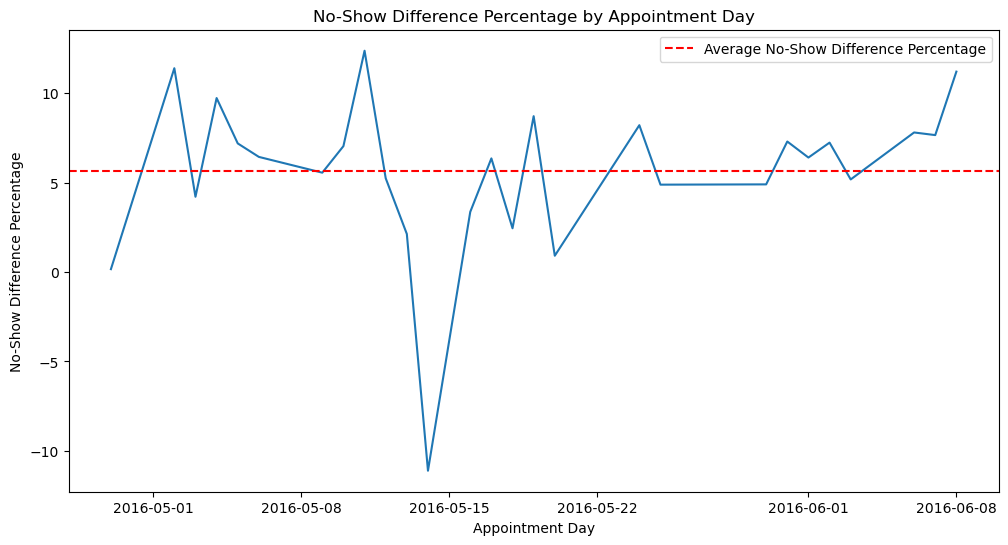

In [388]:
# plotting the no_show_diff_percentage column by the date 
plt.figure(figsize=(12, 6))
sns.lineplot(x='appointmentday', y='adjusted_no_show_diff_%', data=test)
plt.axhline(avg_no_show_diff_percentage_adjusted, color='red', linestyle='--', label='Average No-Show Difference Percentage')
plt.title('No-Show Difference Percentage by Appointment Day')
plt.xlabel('Appointment Day')
plt.ylabel('No-Show Difference Percentage')
plt.legend()
plt.show()

### Now we are running into the event that the model is prediciting more no-shows than what is actually happening. This can be a good thing, but if we adjust the added percent to 5% instead of 10% we can more accurately predict how many people no show. 